Fajar Zulmi Sopian

In [2]:
import zipfile
import os
import glob 
import warnings
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.preprocessing import image
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [3]:
!wget https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip

--2021-06-22 11:34:57--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘rockpaperscissors.zip’

rockpaperscissors.z 100%[===================>] 307.92M   883KB/s    in 5m 42s  

2021-06-22 11:40:40 (921 KB/s) - ‘rockpaperscissors.zip’ saved [322873683/322873683]



In [4]:
ekstrak_zip = 'rockpaperscissors.zip'
out_zip = zipfile.ZipFile(ekstrak_zip, 'r')
out_zip.extractall('/dataset')
out_zip.close()

In [5]:
dir_dataset = "/dataset/rockpaperscissors/rps-cv-images"
dir_paper = os.path.join("/dataset/rockpaperscissors/rps-cv-images/paper")
dir_rock = os.path.join("/dataset/rockpaperscissors/rps-cv-images/rock")
dir_scissors = os.path.join("/dataset/rockpaperscissors/rps-cv-images/scissors")

In [6]:
total_image = len(list(glob.iglob("/dataset/rockpaperscissors/rps-cv-images/*/*.*", recursive=True)))
print("Total Data Image JPEG     : ",total_image)

Total Data Image JPEG     :  2188


In [7]:
total_paper = len(os.listdir(dir_paper))
total_rock = len(os.listdir(dir_rock))
total_scissors = len(os.listdir(dir_scissors))

In [8]:
print("Total Data Paper Image      : ",total_paper)
print("Total Data Rock Image       : ",total_rock)
print("Total Data Scissors Image  : ",total_scissors)

Total Data Paper Image      :  712
Total Data Rock Image       :  726
Total Data Scissors Image  :  750


In [9]:
val_size = 0.2
Train_datagen = ImageDataGenerator(
    rotation_range = 30,
    brightness_range = [0.2,1.0],
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = "nearest",
    rescale = 1./255,
    validation_split = val_size
)

Validation_datagen = ImageDataGenerator(
    rotation_range = 30,
    brightness_range = [0.2,1.0],
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = "nearest",
    rescale = 1./255,
    validation_split = val_size
)

In [10]:
img_width = 200
img_height = 200

In [11]:
Train_generator = Train_datagen.flow_from_directory(
    dir_dataset,
    target_size = (img_width,img_height),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 16,
    shuffle = True,
    subset = "training"
)

Validation_generator = Validation_datagen.flow_from_directory(
    dir_dataset,
    target_size = (img_width,img_height),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 16,
    shuffle = False,
    subset = "validation"
)

Found 1751 images belonging to 3 classes.
Found 437 images belonging to 3 classes.


In [12]:
Model = Sequential(
    [
     Conv2D(32, (3,3), strides = (1,1), activation = 'relu' , input_shape = (img_width,img_height,3)),
     MaxPooling2D(pool_size = (2,2), padding = 'valid'),
     Conv2D(64, (3,3), strides = (1,1), activation = 'relu' ),
     MaxPooling2D(pool_size = (2,2), padding = 'valid'),
     Conv2D(128, (3,3), strides = (1,1), activation = 'relu' ),
     MaxPooling2D(pool_size = (2,2), padding = 'valid'),
     Flatten(),
     Dropout(0.2),
     Dense(128, activation = 'relu'),
     Dense(3, activation='softmax')
    ]
)

In [13]:
Adam(learning_rate=0.00146, name='Adam')
Model.compile(optimizer = 'Adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [14]:
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs', histogram_freq=0, write_graph=True, write_images=False,
    update_freq='epoch', embeddings_freq=0,
    embeddings_metadata=None
)

Model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 67712)             0

In [15]:
batch_size = 16

with tf.device("/device:GPU:0"):
  history = Model.fit(Train_generator, 
                    epochs =  5, 
                    steps_per_epoch = 1751//batch_size, 
                    validation_data = Validation_generator, 
                    verbose = 1, 
                    validation_steps = 437//batch_size,
                    callbacks =[lr_schedule, tb_callback])

Epoch 1/5

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
109/109 [==============================] - 164s 1s/step - loss: 0.7800 - accuracy: 0.6571 - val_loss: 0.5677 - val_accuracy: 0.7824
Epoch 2/5

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
109/109 [==============================] - 161s 1s/step - loss: 0.4181 - accuracy: 0.8490 - val_loss: 0.3156 - val_accuracy: 0.8843
Epoch 3/5

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
109/109 [==============================] - 159s 1s/step - loss: 0.3160 - accuracy: 0.8859 - val_loss: 0.3551 - val_accuracy: 0.8495
Epoch 4/5

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
109/109 [==============================] - 157s 1s/step - loss: 0.2568 - accuracy: 0.9054 - val_loss: 0.2138 - val_accuracy: 0.9097
Epoch 5/5

Epoch 00005: LearningRateScheduler reducing learning rate to 0.001000000047497451

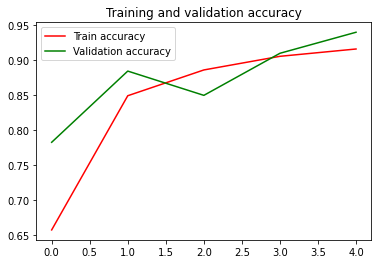

<Figure size 432x288 with 0 Axes>

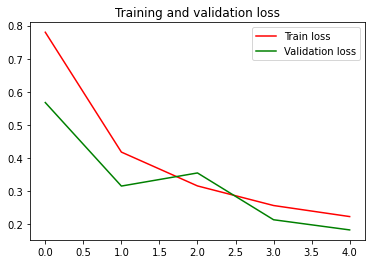

<Figure size 432x288 with 0 Axes>

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Train accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label='Train loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

Saving 0Ug54ifXRqqlZS2Z.png to 0Ug54ifXRqqlZS2Z.png


Hasil Prediksi :  [0. 0. 1.] 

Kategori Gambar : Scissor


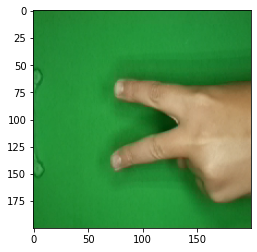

In [18]:
uploaded = files.upload()
for file_upload in uploaded.keys():

  path = file_upload
  img = image.load_img(path, target_size=(200,200))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = Model.predict(images, batch_size=16)
  
  print("\n")
  print('Hasil Prediksi : ',classes[0],'\n')

  if classes[0][0] == 1:
    print('Kategori Gambar : Paper')
  elif classes[0][1] == 1:
    print('Kategori Gambar : Rock')
  else:
    print('Kategori Gambar : Scissor')

In [24]:
warnings.filterwarnings('ignore')
converter = tf.lite.TFLiteConverter.from_keras_model(Model)
tflite_model = converter.convert()
with open('RPS_model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpesm66fr5/assets


INFO:tensorflow:Assets written to: /tmp/tmpesm66fr5/assets
